# Lab 3: Ensembles
## Using trees to detect trees 

We will be using tree-based ensemble methods on the [Covertype dataset](https://www.openml.org/d/180).
It contains about 100,000 observations of 7 types of trees (Spruce, Pine, Cottonwood, Aspen,...) described by 55 features describing elevation, distance to water, soil type, etc.

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [2]:
# Download Covertype data. Takes a while the first time.
covertype = oml.datasets.get_dataset(180)
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array'); 
classes = covertype.retrieve_class_labels()
features = [f.name for i,f in covertype.features.items()][:-1]

C:\Users\Lucas\AppData\Local\Temp\ipykernel_2532\2692424945.py:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  covertype = oml.datasets.get_dataset(180)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_2532\2692424945.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array');


In [3]:
classes

['Aspen',
 'Cottonwood_Willow',
 'Douglas_fir',
 'Krummholz',
 'Lodgepole_Pine',
 'Ponderosa_Pine',
 'Spruce_Fir']

In [4]:
features[0:20]

['elevation',
 'aspect',
 'slope',
 'horizontal_distance_to_hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'wilderness_area1',
 'wilderness_area2',
 'wilderness_area3',
 'wilderness_area4',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6']

To understand the data a bit better, we can use a scatter matrix. From this, it looks like elevation is a relevant feature.
Douglas Fir and Aspen grow at low elevations, while only Krummholz pines survive at very high elevations.

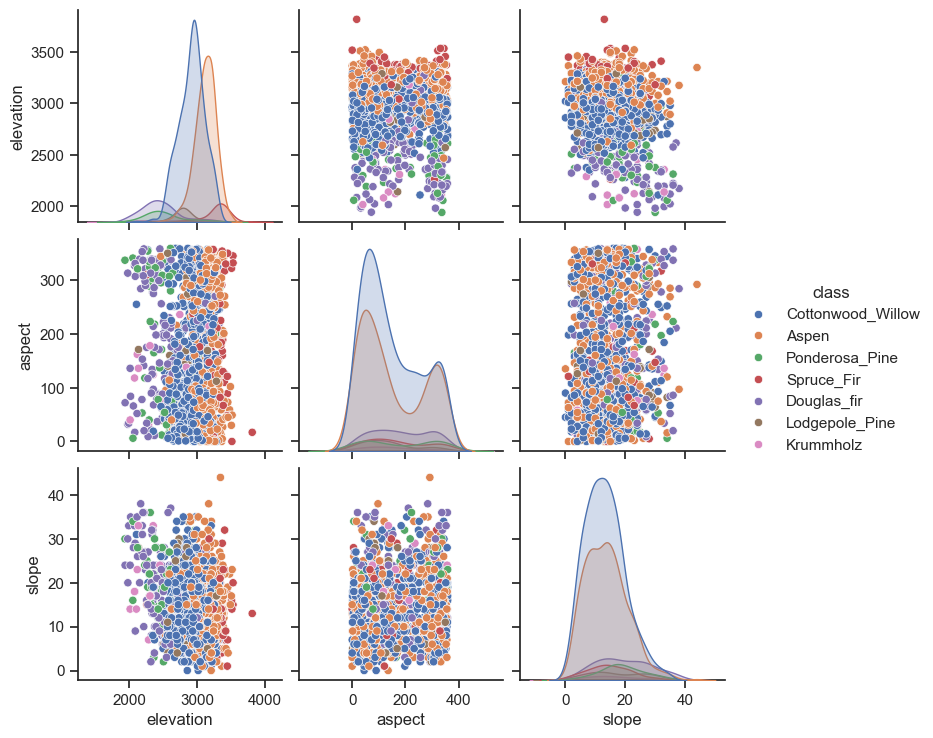

In [5]:
# Using seaborn to build the scatter matrix
# only first 3 columns, first 1000 examples
n_points = 1500
df = pd.DataFrame(X[:n_points,:3], columns=features[:3])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class");

## Exercise 1: Random Forests
Implement a function `evaluate_RF` that measures the performance of a Random Forest Classifier, using trees
of (max) depth 2,8,32,64, for any number of trees in the ensemble (`n_estimators`). 
For the evaluation you should measure accuracy using 3-fold cross-validation. 
Use `random_state=1` to ensure reproducibility. Finally, plot the results for at least 5 values of `n_estimators` ranging from 1 to 30. You can, of course, reuse code from earlier labs and assignments. Interpret the results.
You can take a 50% subsample to speed the plotting.

[1, 6, 11, 16, 21, 26, 31]
[2, 8, 32, 64]


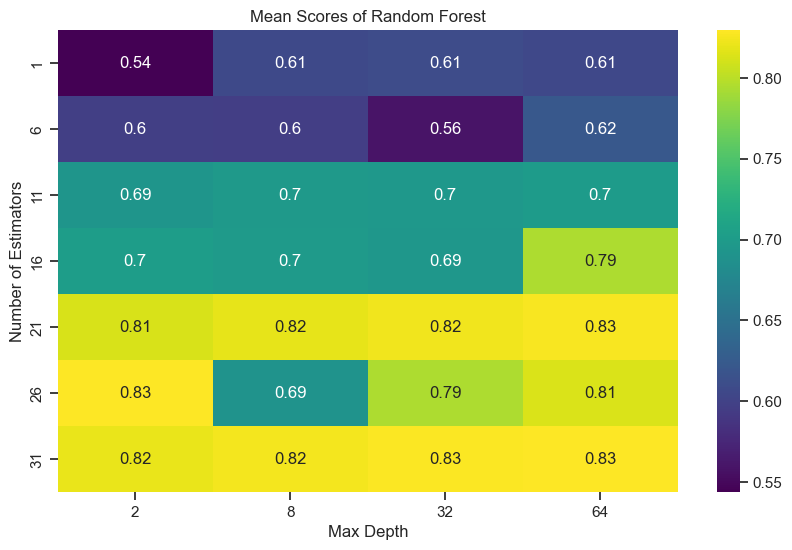

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_RF(X_train, y_train, metric="accuracy", depth=None):
    grid = {'n_estimators': range(1, 32, 5)}
    if depth is None:
        grid['max_depth'] = [2, 8, 32, 64]
        rf = RandomForestClassifier(random_state=1) 
    else:
        rf = RandomForestClassifier(random_state=1, max_depth=depth)
    cv = GridSearchCV(rf, grid, scoring=metric, cv=3).fit(X_train, y_train)
    
    # Extract the results from the grid search
    results = cv.cv_results_
    n_estimators = list(grid['n_estimators'])
    print(n_estimators)
    if depth is None:
        max_depths = grid['max_depth']
        print(max_depths)
    else:
        max_depths = [depth]
    mean_scores = results['mean_test_score']

    # Creat heat plot
    mean_scores = mean_scores.reshape(len(n_estimators), len(max_depths))

    # Add axis ticks and labels
    # Create a dataframe with the mean scores
    df_scores = pd.DataFrame(mean_scores, index=n_estimators, columns=max_depths)

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_scores, annot=True, cmap='viridis')
    plt.xlabel('Max Depth')
    plt.ylabel('Number of Estimators')
    plt.title('Mean Scores of Random Forest')
    plt.show()

    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, shuffle=True)
evaluate_RF(X_train, y_train)


The max depth and number of iterators should both be high. This makes sense as the random forest works best when the estimators overfit but there are multiple of them.

## Exercise 2: Other measures
Repeat the same plot but now use balanced_accuracy as the evaluation measure. See the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).
Only use the optimal max_depth from the previous question. Do you see an important difference?

[1, 6, 11, 16, 21, 26, 31]


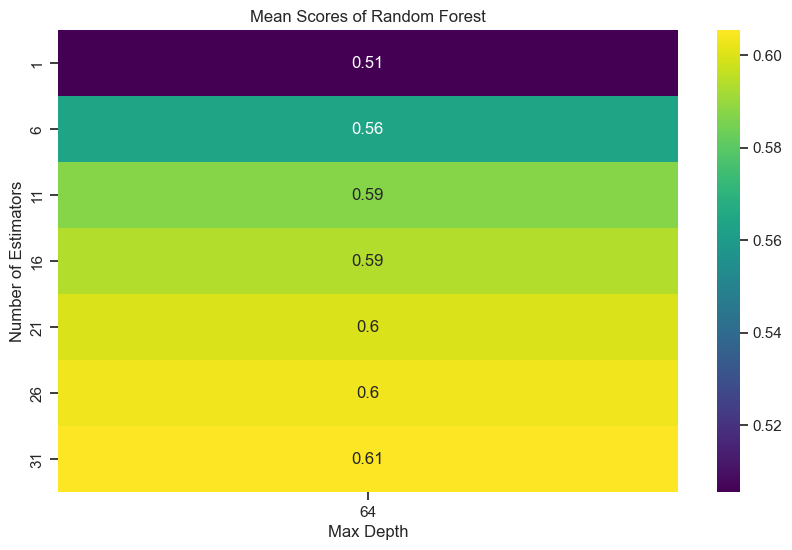

In [36]:
acc = evaluate_RF(X_train, y_train, "balanced_accuracy", depth=64)

The accuracy is lower which makes sense since the data is imbalanced. The optimum still seems to lie around 30 estimators.

## Exercise 3: Feature importance
Retrieve the feature importances according to the (tuned) random forest model. Which feature are most important?

In [37]:
# Print rf feature importance
rf = RandomForestClassifier(max_depth=64, n_estimators=30)
rf.fit(X_train, y_train)
# Display the feature importances in a human readable form
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(15):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. elevation (0.224502)
2. Horizontal_Distance_To_Roadways (0.101162)
3. Horizontal_Distance_To_Fire_Points (0.095493)
4. horizontal_distance_to_hydrology (0.066059)
5. Vertical_Distance_To_Hydrology (0.064169)
6. aspect (0.059873)
7. Hillshade_Noon (0.056930)
8. Hillshade_3pm (0.055235)
9. Hillshade_9am (0.055232)
10. slope (0.045563)
11. wilderness_area4 (0.031138)
12. soil_type_4 (0.011687)
13. wilderness_area3 (0.011255)
14. soil_type_22 (0.010588)
15. wilderness_area1 (0.009407)


## Exercise 4: Feature selection
Re-build your tuned random forest, but this time only using the first 10 features.
Return both the balanced accuracy and training time. Interpret the results.

In [38]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np
# Get the feature importances
importances = rf.feature_importances_

# Sort the feature columns by their importances
sorted_index = np.argsort(importances)[::-1]

# Create X_pruned which only contains the 10 most important feature columns
X_pruned = X_train[:, sorted_index[:10]]
print(X_pruned.shape, X_train.shape)
features_pruned = [features[i] for i in sorted_index[:10]]
print("The 10 most important features are:")
print(features_pruned)

# Train random forest on the pruned dataset
rf = RandomForestClassifier(max_depth=64, n_estimators=30)
rf.fit(X_pruned, y_train)

# Evaluate by the balanced accuracy 
X_test_pruned = X_test[:, sorted_index[:10]]
y_pred = rf.predict(X_test_pruned)
balanced_accuracy_score(y_test, y_pred)

(55196, 10) (55196, 54)
The 10 most important features are:
['elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'horizontal_distance_to_hydrology', 'Vertical_Distance_To_Hydrology', 'aspect', 'Hillshade_Noon', 'Hillshade_3pm', 'Hillshade_9am', 'slope']


0.6057594414459591

Accuracy is the same but training time a lot faster, this makes sense since we removed features that had little predictive value

## Exercise 5: Confusion matrix
Do a standard stratified holdout and generate the confusion matrix of the tuned random forest. Which classes are still often confused?

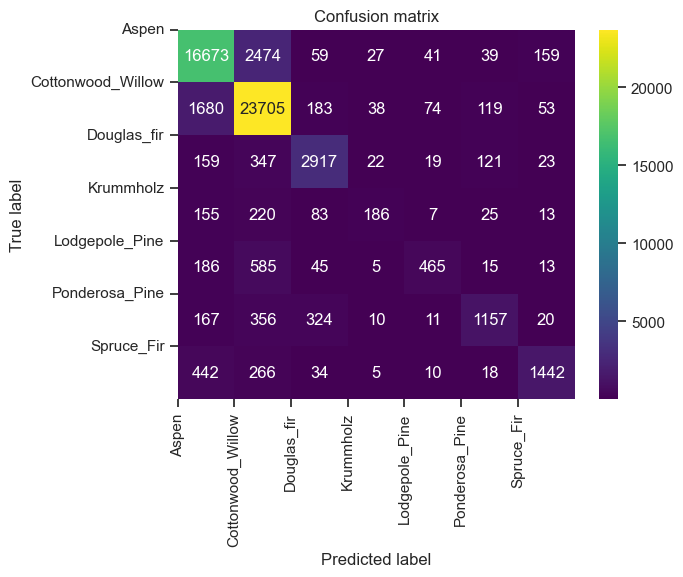

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Train the random forest
rf = RandomForestClassifier(max_depth=64, n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Show confusion matrix
conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
# Set ticks based on the subset of selected columns
plt.xticks(range(len(classes)), labels=classes, rotation=90)
plt.yticks(range(len(classes)), labels=classes, rotation=0)
plt.show()

Cottomwood willows and aspen are confused the most often.
The two pine species are confused the second most often.

## Exercise 6: A second-level model
Build a binary model specifically to correctly choose between the first and the second class.
Select only the data points with those classes and train a new random forest. Do a standard stratified split and plot the resulting ROC curve. Can we still improve the model by calibrating the threshold?

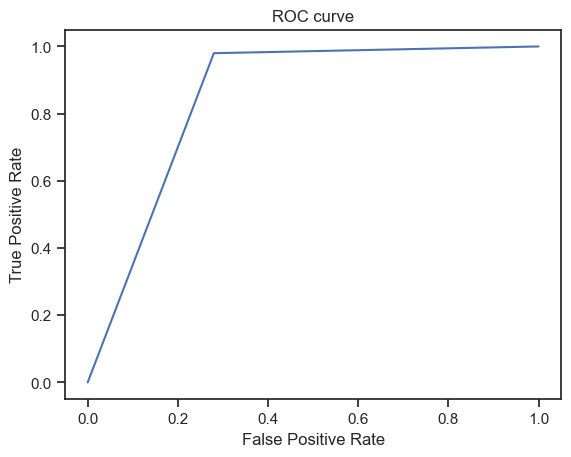

In [46]:
from sklearn.metrics import roc_curve
# Filter y to only have class 1 or 2
X_train_binary = X_train[y_train < 2]
X_test_binary = X_test[y_test < 2]
y_train_binary = y_train < 2
y_test_binary = y_test < 2
# Train randomforest
rf = RandomForestClassifier(max_depth=64, n_estimators=30)
rf.fit(X_train_binary, y_train_binary)
# Predict on test set
y_pred_binary = rf.predict(X_test_binary)
# Plot ROC curve of y_pred_binary and y_test_binary
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

The best thing would be to select the elbow since this is where the true positive rate is the highest while having the lowest false positive rate.

## Exercise 7: Model calibration
For the trained binary random forest model, plot a calibration curve (see [course notebook](https://ml-course.github.io/engineer/slides_html/03%20-%20Model%20Selection.slides.html#/40)). 
Next, try to correct for this using Platt Scaling (or sigmoid scaling).

Probability calibration should be done on new data not used for model fitting. The class [CalibratedClassifierCV](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) uses a cross-validation generator and estimates for each split the model parameter on the train samples and the calibration of the test samples. The probabilities predicted for the folds are then averaged. Already fitted classifiers can be calibrated by CalibratedClassifierCV via the parameter cv=”prefit”. [Read more](https://scikit-learn.org/stable/modules/calibration.html)

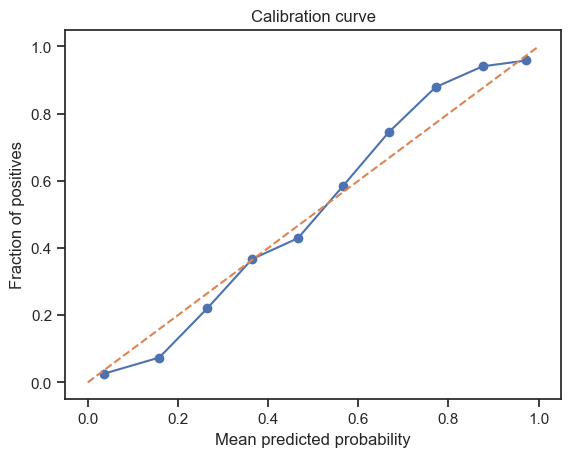

In [47]:
# plot calibration curve
from sklearn.calibration import calibration_curve
# Get probability estimates
y_prob = rf.predict_proba(X_test_binary)[:, 1]
# Plot calibration curve
prob_true, prob_pred = calibration_curve(y_test_binary, y_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.show()

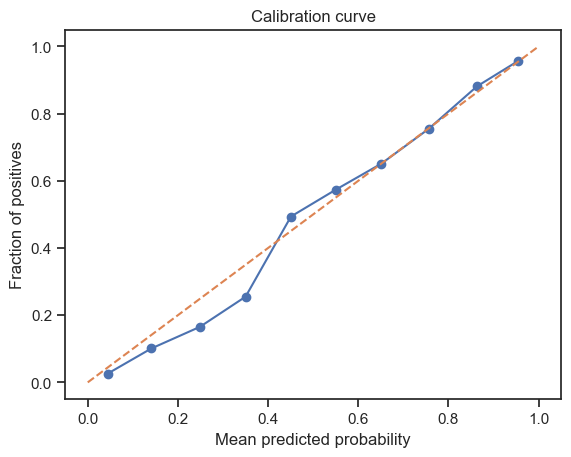

In [48]:
from sklearn.calibration import CalibratedClassifierCV
cv = CalibratedClassifierCV(RandomForestClassifier(max_depth=64, n_estimators=30, random_state=1), cv=3)
cv.fit(X_train_binary, y_train_binary)
y_prob_cv = cv.predict_proba(X_test_binary)[:, 1]
prob_true_cv, prob_pred_cv = calibration_curve(y_test_binary, y_prob_cv, n_bins=10)
plt.plot(prob_pred_cv, prob_true_cv, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.show()

## Exercise 8: Gradient Boosting
Implement a function `evaluate_GB` that measures the performance of `GradientBoostingClassifier` or the `XGBoostClassifier` for 
different learning rates (0.01, 0.1, 1, and 10). As before, use a 3-fold cross-validation. You can use a 5% stratified sample of the whole dataset.
Finally plot the results for `n_estimators` ranging from 1 to 100. Run all the GBClassifiers with `random_state=1` to ensure reproducibility.

Implement a function that plots the score of `evaluate_GB` for `n_estimators` = 10,20,30,...,100 on a linear scale.

In [50]:

def evaluate_GB(model, X_train, y_train):
    grid = {"n_estimators": range(10, 110, 10), "learning_rate": [0.01, 0.01, 1, 10]}
    cv = GridSearchCV(model, grid, scoring="balanced_accuracy", cv=3).fit(X_train, y_train)
    results = cv.cv_results_
    n_estimators = list(grid['n_estimators'])
    learning_rates = list(grid['learning_rate'])
    mean_scores = results['mean_test_score']
    mean_scores = mean_scores.reshape(len(n_estimators), len(learning_rates))
    df_scores = pd.DataFrame(mean_scores, index=n_estimators, columns=learning_rates)
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_scores, annot=True, cmap='viridis')
    plt.xlabel('Learning Rate')
    plt.ylabel('Number of Estimators')
    plt.title('Mean Scores of Gradient Boosting')
    plt.show()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.96, random_state=1, shuffle=True)
from sklearn.ensemble import GradientBoostingClassifier, XGBoostClassifier
evaluate_GB(GradientBoostingClassifier(random_state=1), X_train, y_train)

In [ ]:
evaluate_GB(XGBoostClassifier(random_state=1), X_train, y_train)